# ABS Retail Trade 8501

Note: the ABS usually releases the Retail Trade data in tranches, with the second tranch delivered about a week after the first.

## Python set-up

In [1]:
# system imports
from typing import cast

# analytic imports
import matplotlib.pyplot as plt
import pandas as pd

# local imports
from abs_data_capture import (
    fix_abs_title,
    get_abs_meta_and_data,
    get_fs_constants,
    get_meta_constants,
    get_plot_constants,
)
from plotting import (
    calc_growth,
    clear_chart_dir,
    plot_covid_recovery,
    plot_growth_finalise,
    recalibrate_series,
    recalibrate,
    set_chart_dir,
    finalise_plot,
)
from decompose import decompose
from utility import qtly_to_monthly


# pandas display settings
pd.options.display.max_rows = 999999
pd.options.display.max_columns = 999

# display charts in the notebook ...
SHOW = True

## Get data from the ABS

### Retail trade data

In [2]:
# get ABS retail data
RETAIL_CAT_ID = "8501"
source, CHART_DIR, META_DATA = get_fs_constants(RETAIL_CAT_ID)
retail_dict = get_abs_meta_and_data(
    RETAIL_CAT_ID,
    # verbose=True
)

retail_meta = retail_dict[META_DATA]
RECENT, plot_times, plot_tags = get_plot_constants(retail_meta)
(
    did_col,
    id_col,
    table_col,
    type_col,
    unit_col,
    tdesc_col,
) = get_meta_constants()

Found URL for a ZIP file on ABS web page
About to download and cache the latest data.
Saving to cache: ABS_CACHE/0152173c9bd9b3811cc5064bc72e98b0--All-Time-Series-Spreadsheets.zip
Extracting DataFrames from the zip-file ...


In [3]:
# Check latest monthly date
print(retail_dict["1"].index[-1])

2023-12


In [4]:
# check latest quarterly date
if "7" in retail_dict:
    print(retail_dict["7"].index[-1])

In [5]:
# Monthly tables are numbered 1 through 4
# Quarterly tables are numbered 5 and following.
print(retail_meta["Table"].unique())

['1' '2' '3' '4']


### CPI deflator

In [6]:
def get_cpi_deflator() -> tuple[pd.Series, str, str]:
    """Get CPI deflator, including a forward projection."""

    # get CPI tables from the ABS
    cpi_catalogue_id = "6401"
    cpi_dict = get_abs_meta_and_data(cpi_catalogue_id)
    cpi_meta = cpi_dict[META_DATA]

    # extract quarterly All Groups CPI index from the ABS data
    cpi_index = "Index Numbers ;  All groups CPI ;  Australia ;"
    cpi_table = "2"
    cpi_row = cpi_meta[
        (cpi_meta[did_col] == cpi_index) & (cpi_meta[table_col] == cpi_table)
    ].iloc[0]
    cpi_id = cpi_row[id_col]
    cpi_q = cpi_dict[cpi_table][cpi_id]

    # rebase quarterly CPI index to one
    cpi_q = cpi_q / cpi_q.iloc[-1]

    # calculate recent monthly CPI growth
    months_per_quarter = 3
    quarters = 2
    period = months_per_quarter * quarters  # in months
    monthly_growth = (cpi_q.iloc[-1] / cpi_q.iloc[-1 - quarters]) ** (1 / period)

    # create a monthly CPI index ...
    cpi_m = qtly_to_monthly(cpi_q)

    # extrapolate monthly index forward ...
    additional_months = 4
    for _ in range(additional_months):
        cpi_m[cpi_m.index[-1] + 1] = cpi_m.iloc[-1] * monthly_growth

    print()
    print(f"Monthly growth: {monthly_growth}")
    print(f"Projected CPI: {cpi_m.tail(12)}")
    return cpi_m, cpi_catalogue_id, cpi_table


cpi_deflator, CPI_CAT_ID, CPI_TABLE = get_cpi_deflator()

Found URL for a ZIP file on ABS web page
Retrieving data from cache: ABS_CACHE/5f6bd6bc84c24ad0c445fc096bd08fbd--All-Time-Series-Spreadsheets.zip
Extracting DataFrames from the zip-file ...

Monthly growth: 1.0033652259388404
Projected CPI: Series ID
2023-03    0.980044
2023-04    0.982754
2023-05    0.985464
2023-06    0.988174
2023-07    0.992116
2023-08    0.996058
2023-09    1.000000
2023-10         NaN
2023-11         NaN
2023-12         NaN
2024-01         NaN
2024-02         NaN
Freq: M, Name: A2325846C, dtype: float64


## Plot - retail turnover by industry

### Plotting initialisation / constants

In [7]:
def chart_settings(chart_dir: str = CHART_DIR) -> None:
    """Set up charting parameters."""

    set_chart_dir(chart_dir)
    clear_chart_dir(chart_dir)
    plt.style.use("fivethirtyeight")


chart_settings()
LONG_LABEL = 35  # characters

### Main plotting loop

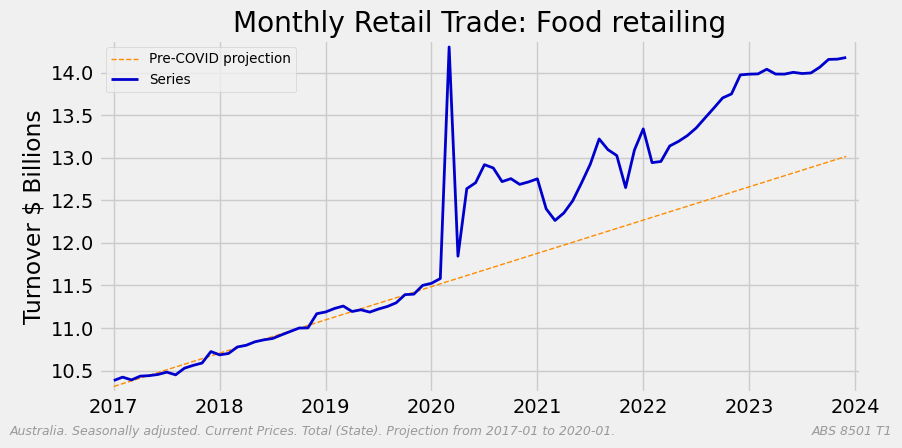

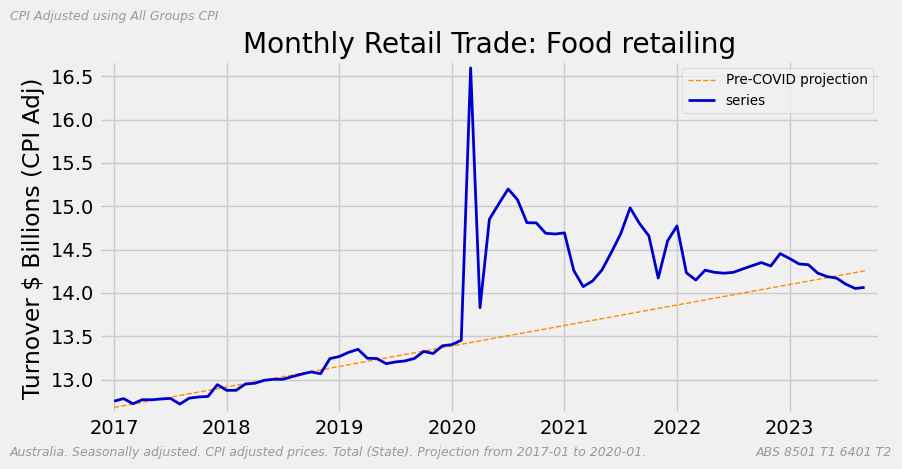

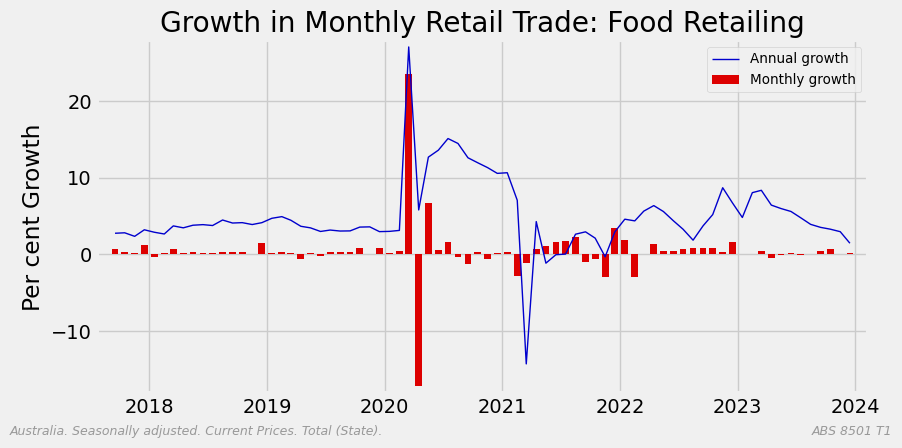

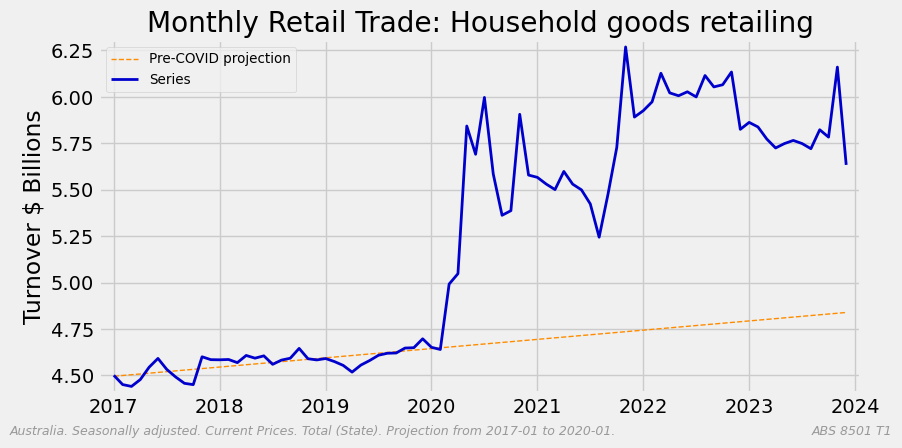

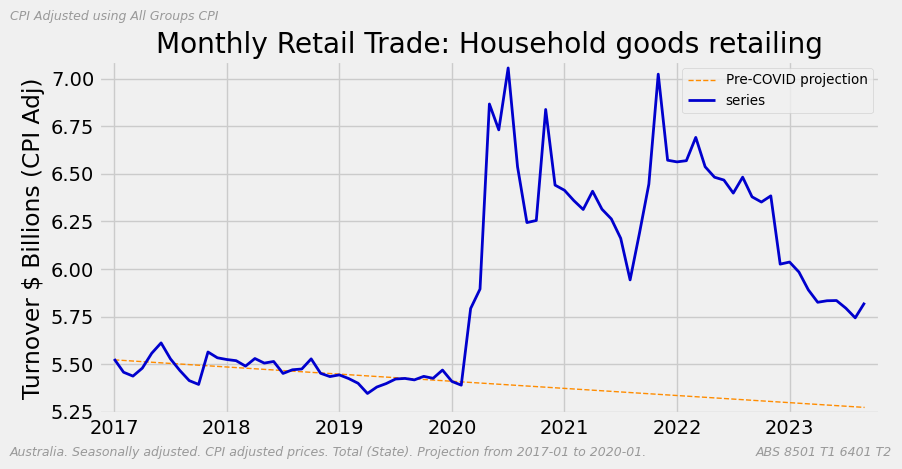

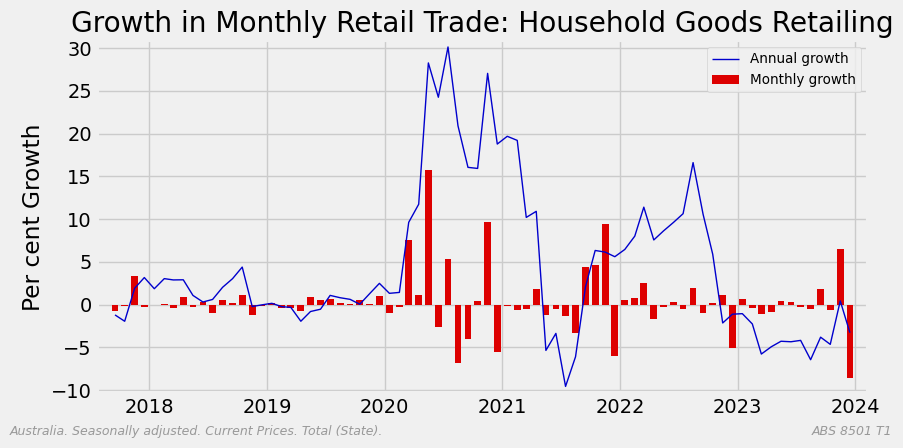

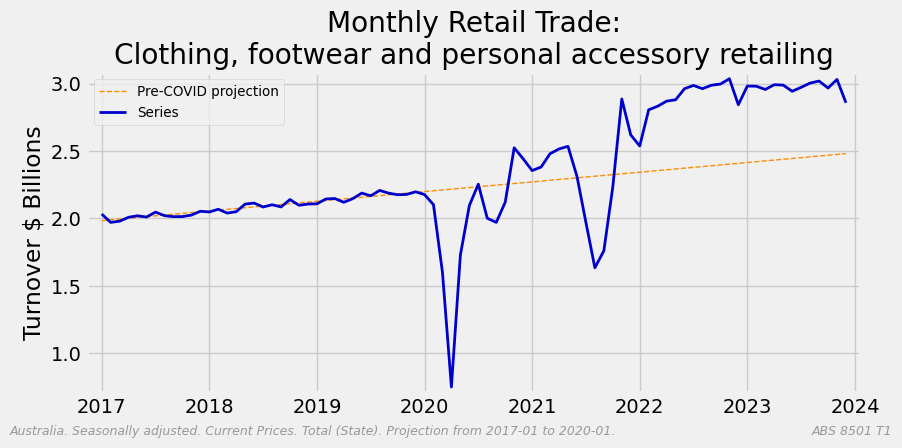

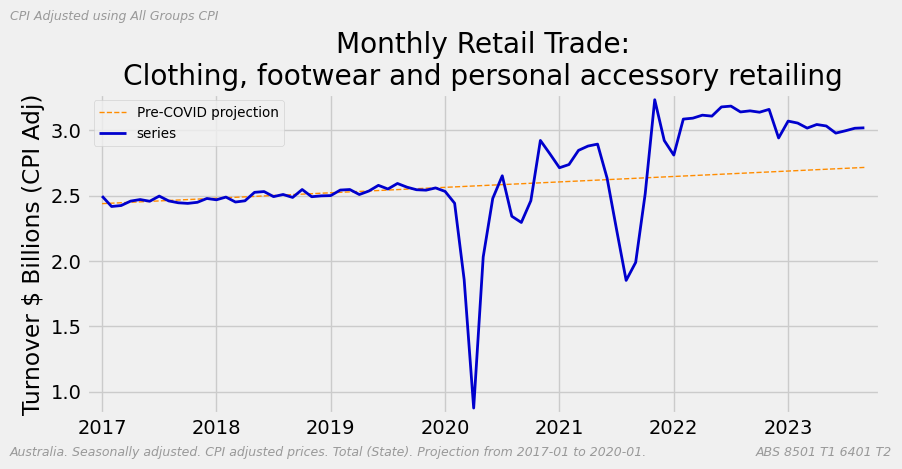

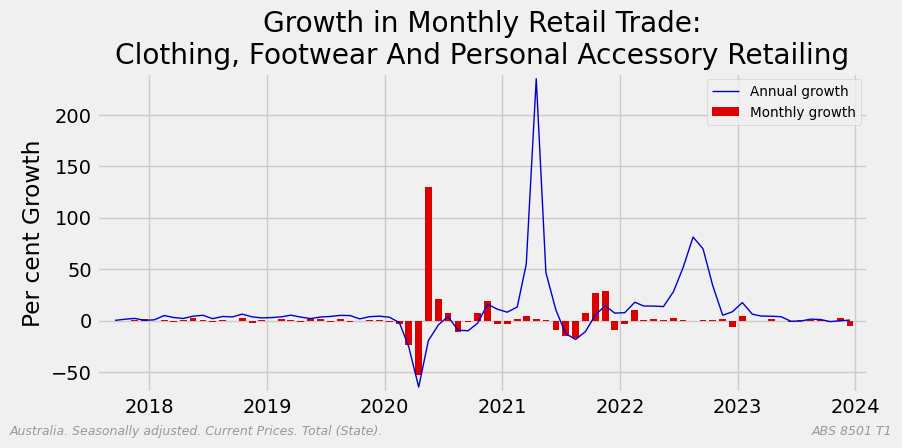

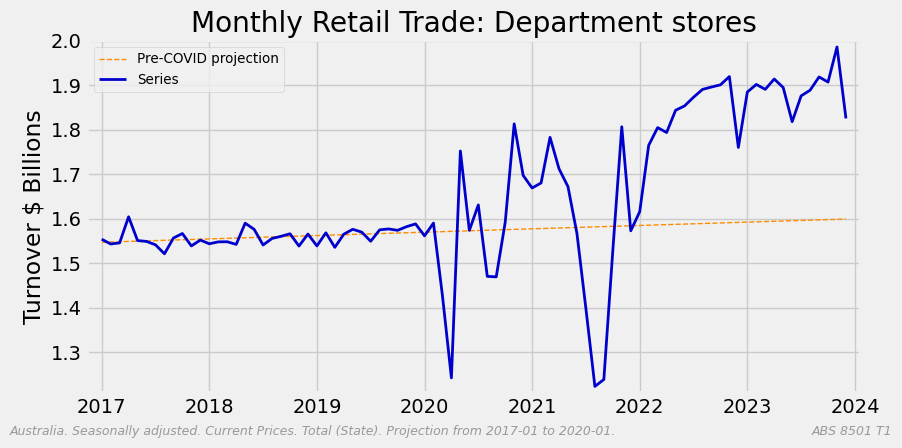

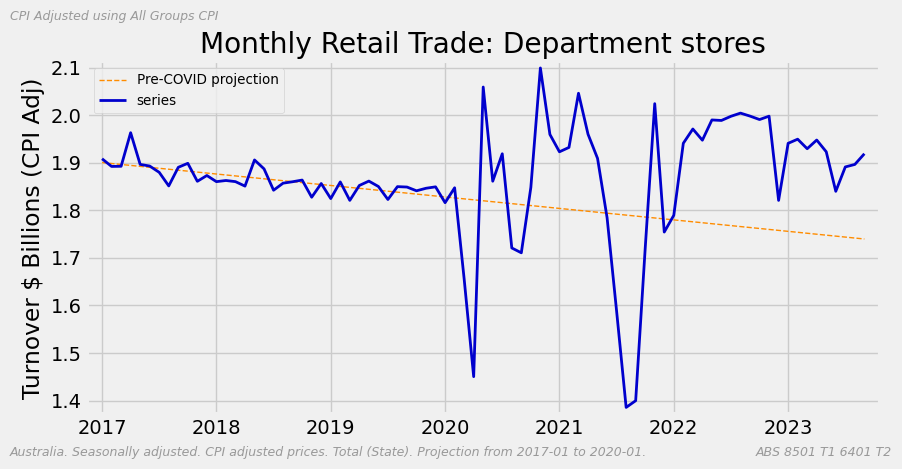

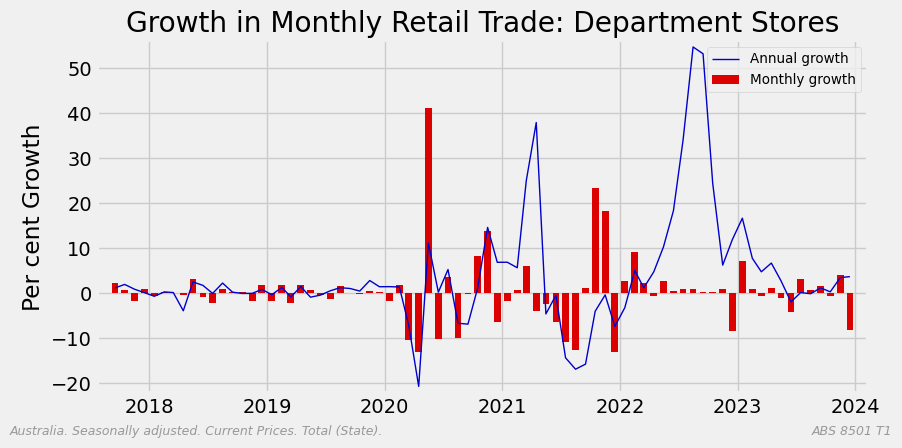

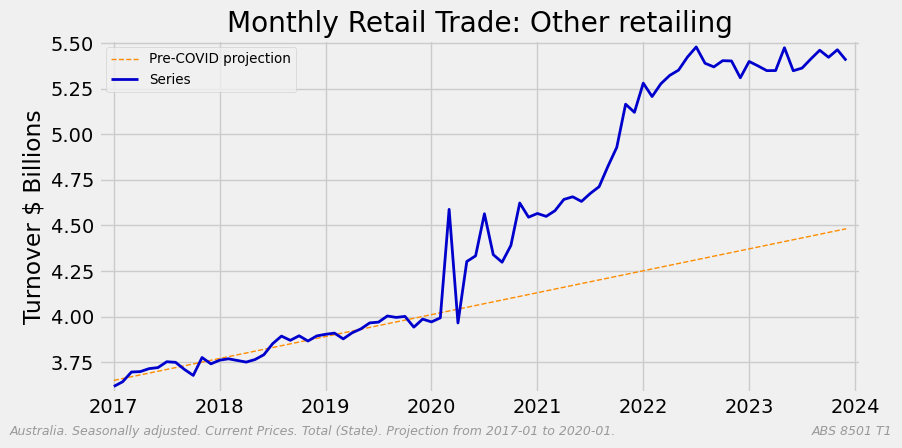

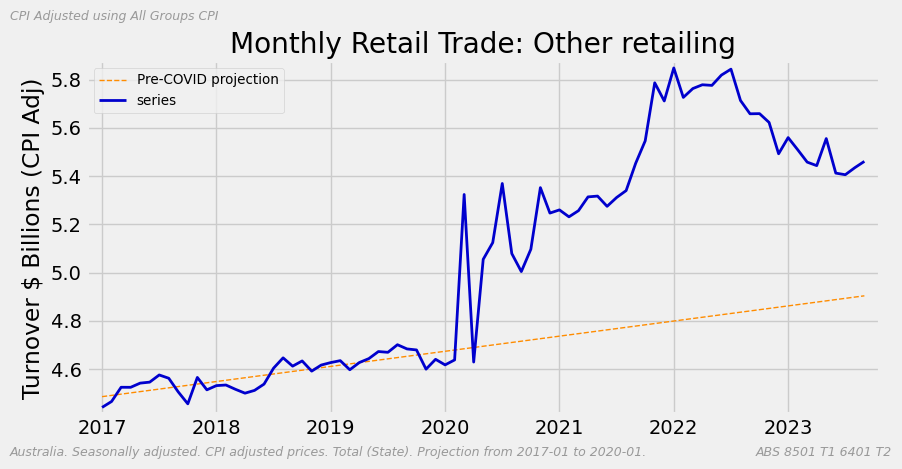

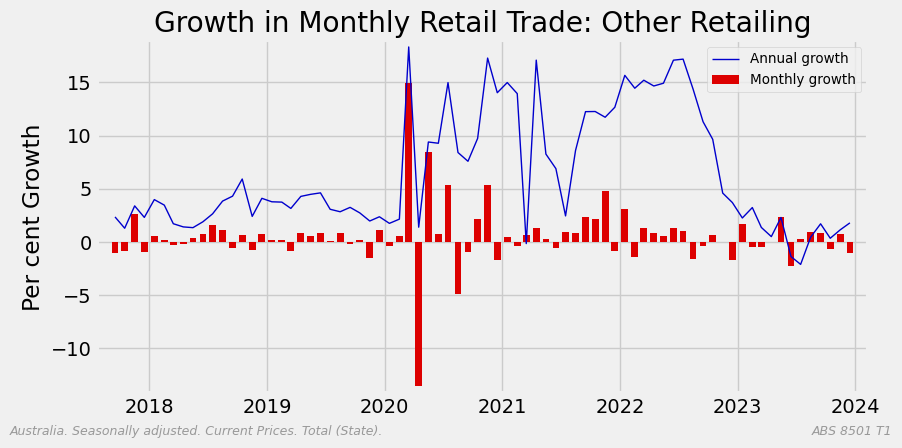

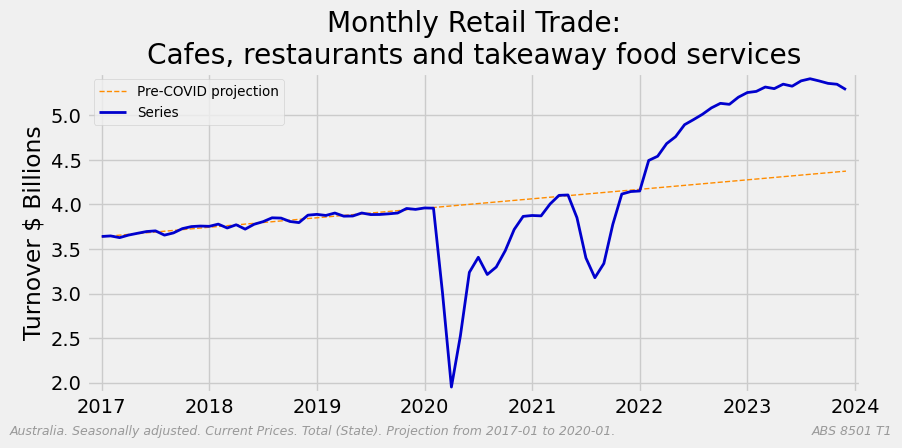

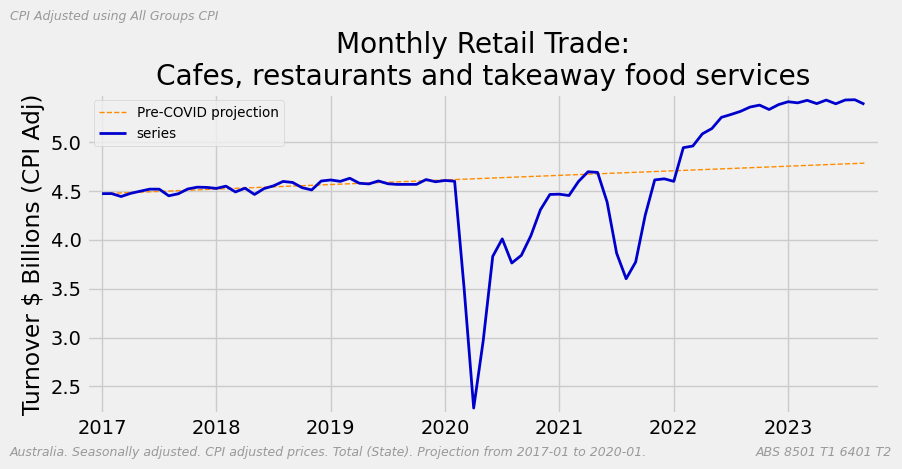

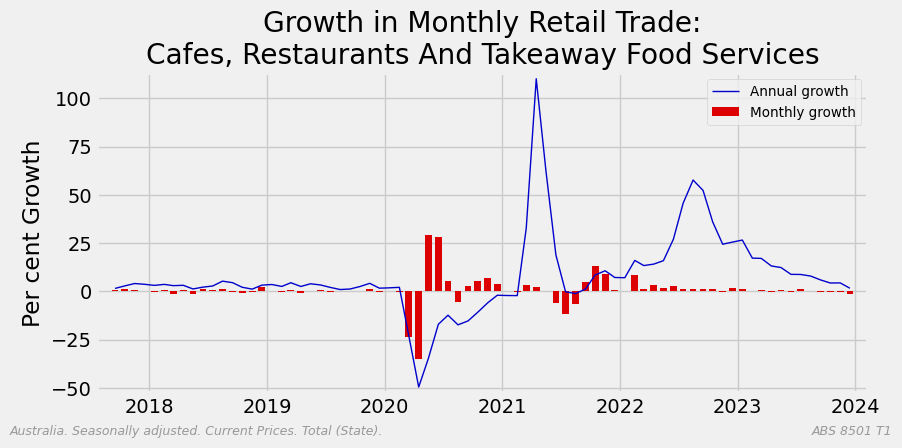

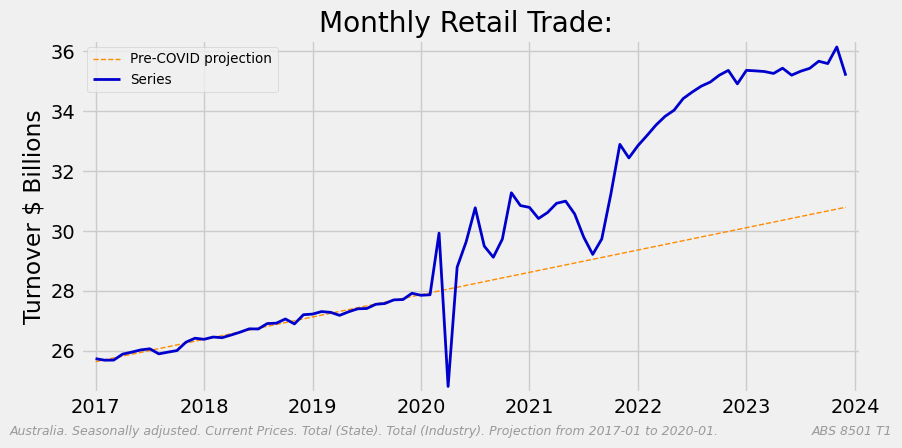

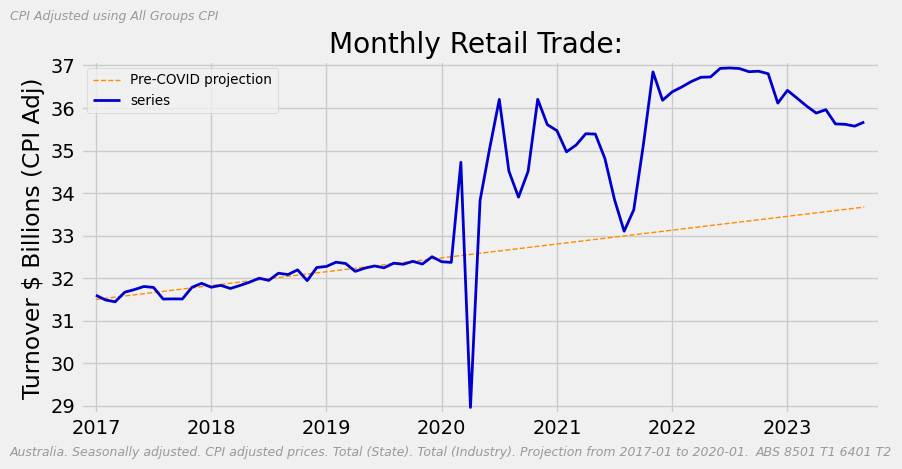

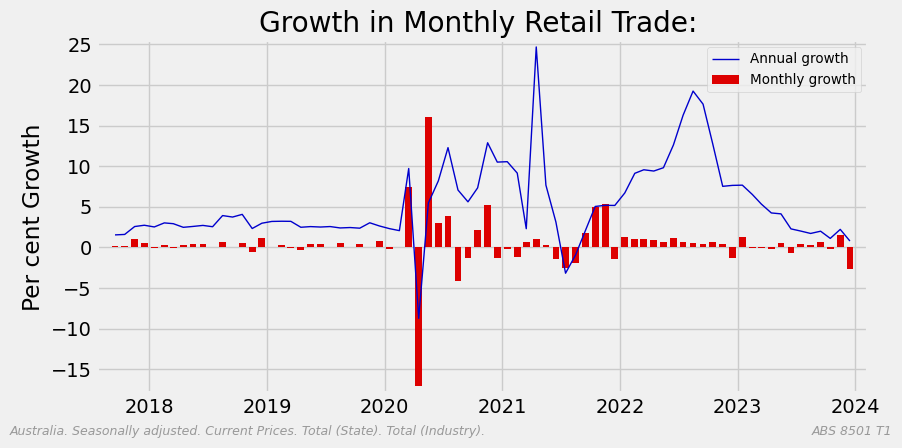

In [8]:
def produce_charts() -> None:
    """Produce charts."""

    series_type = "Seasonally Adjusted"
    rows = retail_meta[
        retail_meta[did_col].str.contains("Turnover", regex=False)
        & retail_meta[unit_col].str.contains("$", regex=False)
        & (retail_meta[type_col] == series_type)
    ]

    recent = plot_times[1]
    for _, row in rows.iterrows():
        # get the data for wacg plotable item
        series_id, units, table = row[id_col], row[unit_col], row[table_col]
        data = retail_dict[table]
        series, units = recalibrate_series(data[series_id], units)
        series_freq = cast(pd.PeriodIndex, series.index).freqstr
        check = pd.Period("2017-01-01", freq=series_freq)
        check_series = series[series.index > check]
        if len(check_series) != len(check_series.dropna()):
            print(f"Odd or missing data: {row[did_col]}")
            continue

        # plot the data
        headline = "!"
        pre_tag = headline if table in ["1", "7"] else ""
        series.name = "Series"
        monthly = "Monthly"
        frequency = {"Q": "Quarterly", "M": monthly}[series_freq[0]]
        lfooter = f"Australia. {series_type.capitalize()}. "
        current_prices = "Current Prices. "
        lfooter += "Current Prices. " if frequency == monthly else ""
        title, lfooter = fix_abs_title(row[did_col], lfooter)
        separator = "\n" if len(title) > LONG_LABEL else " "
        title = (
            f"{frequency} Retail Trade:{separator}"
            # Move "Turnover" to the y-axis label.
            f"{title.replace('Turnover', '').strip()}"
        )
        plot_covid_recovery(
            series,
            title=title,
            ylabel=f"Turnover {units}",
            pre_tag=pre_tag,
            rfooter=f"{source} T{table}",
            lfooter=lfooter,
            show=pre_tag == headline and SHOW,
        )

        if pre_tag == headline and frequency == monthly:
            cpi_adj_series = (series / cpi_deflator).dropna()
            cpi_adj_series.name = "series"
            plot_covid_recovery(
                cpi_adj_series,
                title=title,
                ylabel=f"Turnover {units} (CPI Adj)",
                pre_tag=pre_tag,
                tags="cpi-adjusted",
                rfooter=f"{source} T{table} {CPI_CAT_ID} T{CPI_TABLE}",
                lfooter=lfooter.replace(current_prices, "CPI adjusted prices. "),
                lheader="CPI Adjusted using All Groups CPI",
                show=pre_tag == headline and SHOW,
            )

        if pre_tag == headline:
            # Only do growth charts on headline items
            growth = calc_growth(series)
            plot_growth_finalise(
                *growth,
                from_=pd.Period(recent, freq=cast(pd.PeriodIndex, series.index).freqstr[0]),
                title=f"Growth in {title.title()}",
                pre_tag=headline,
                rfooter=f"{source} T{table}",
                lfooter=lfooter,
                show=SHOW,
            )


produce_charts()

### Seasonal adjustment check

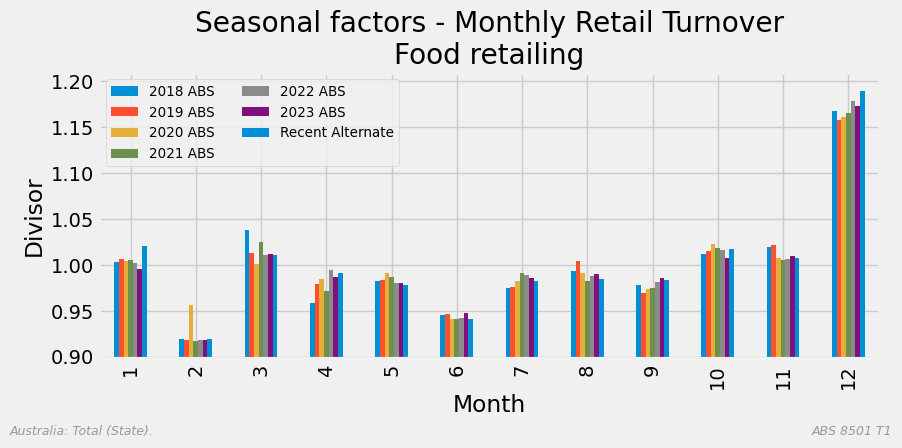

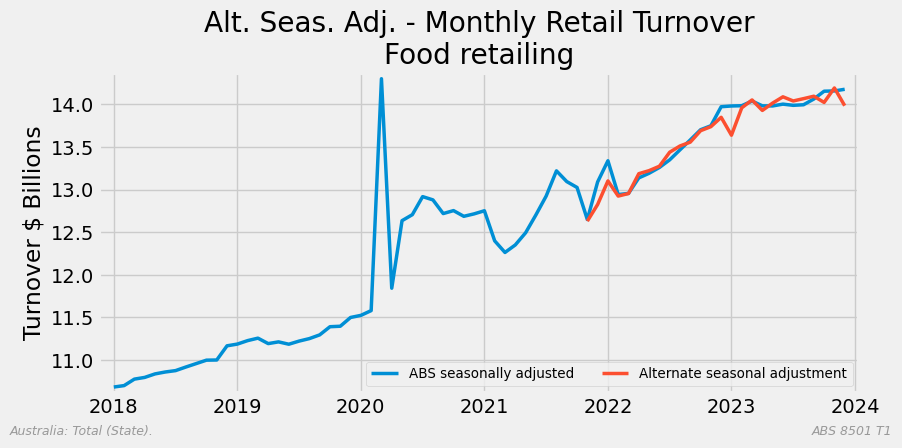

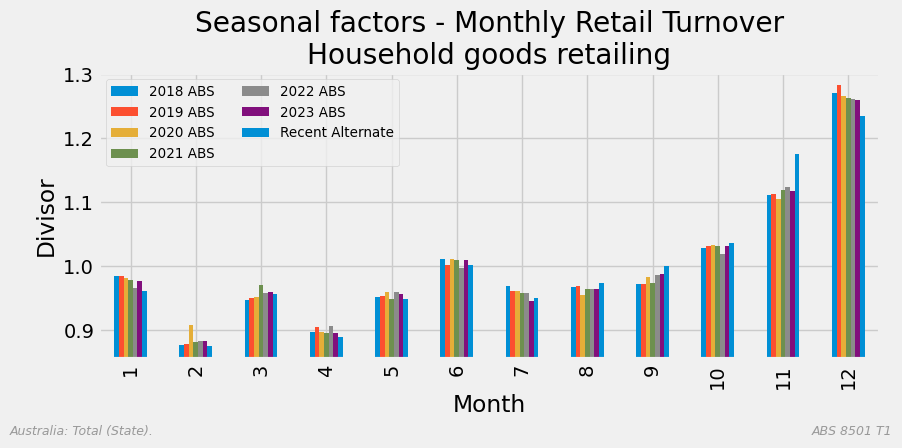

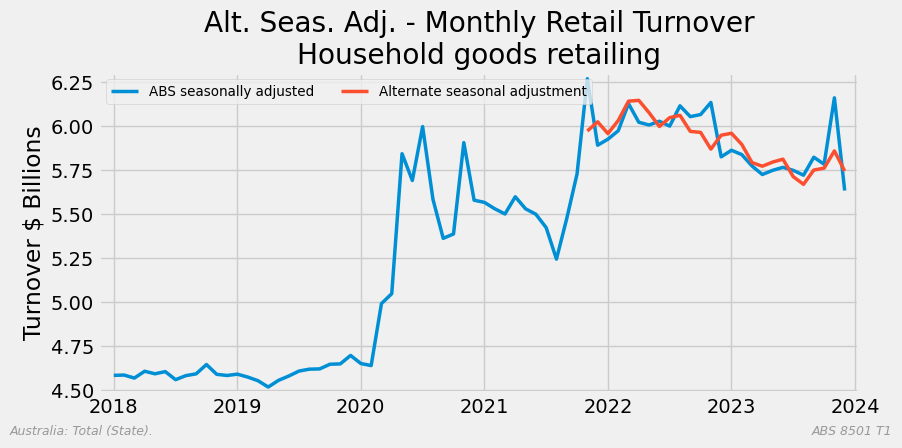

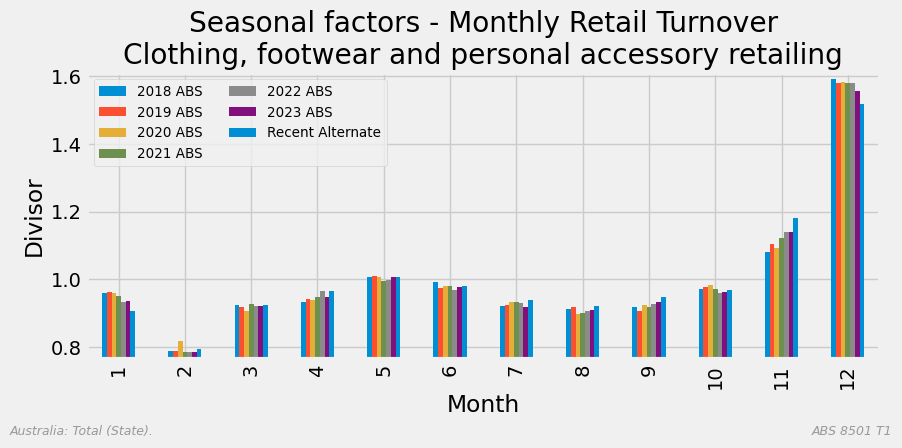

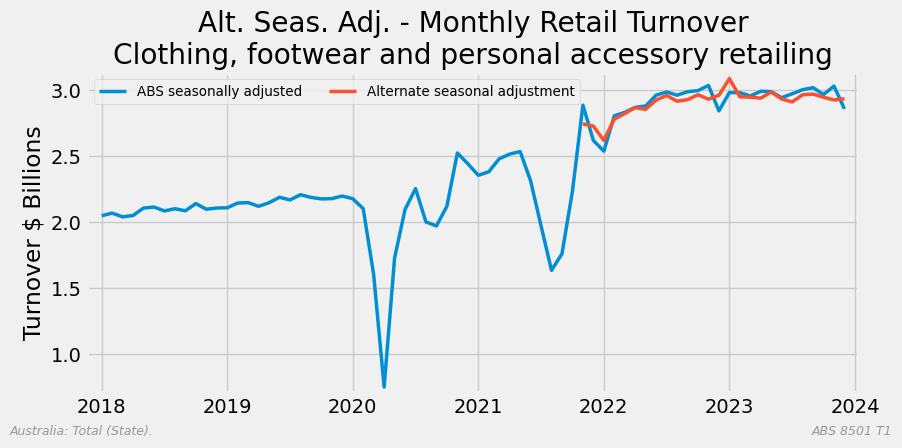

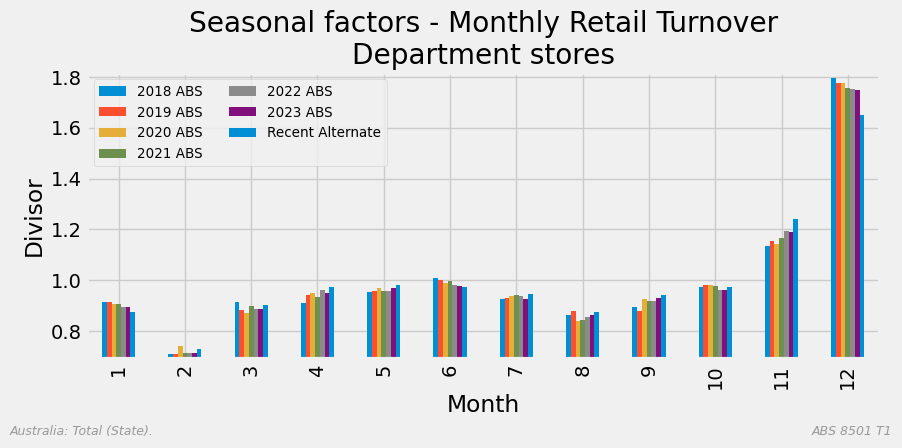

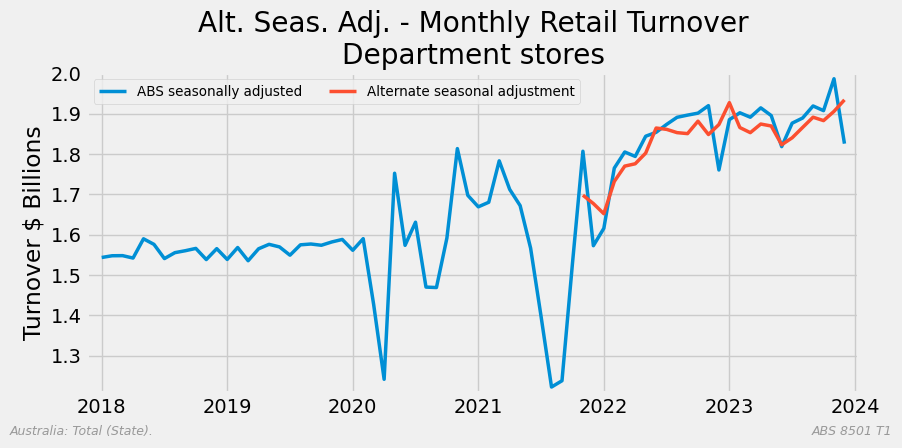

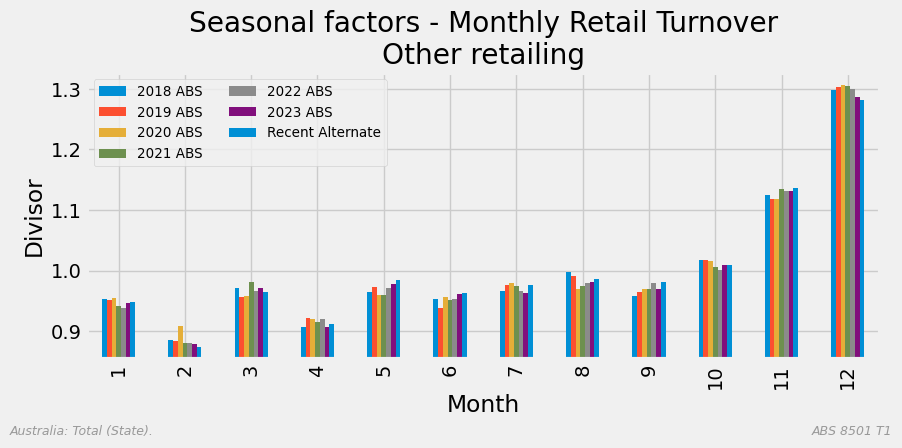

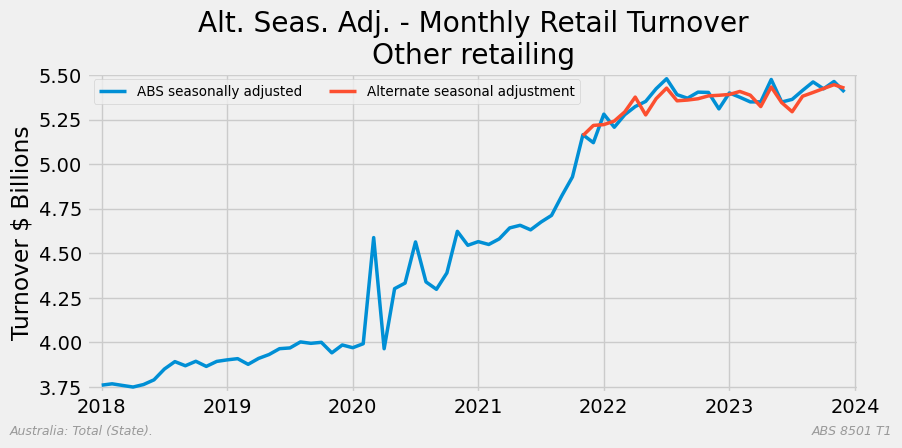

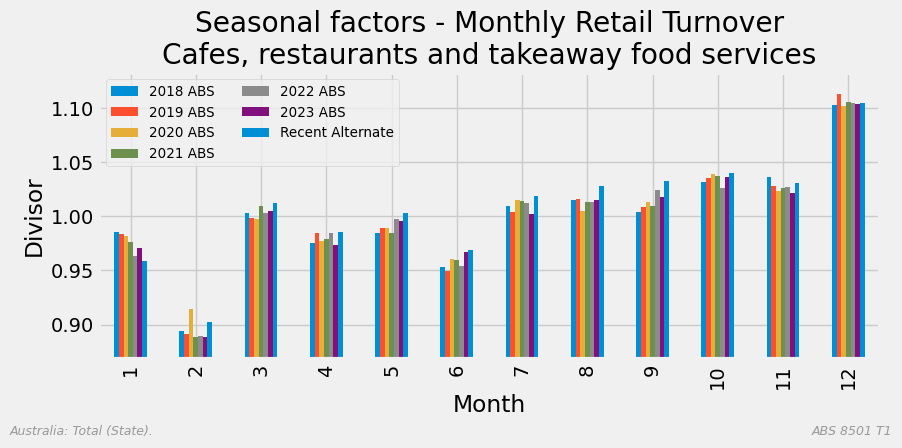

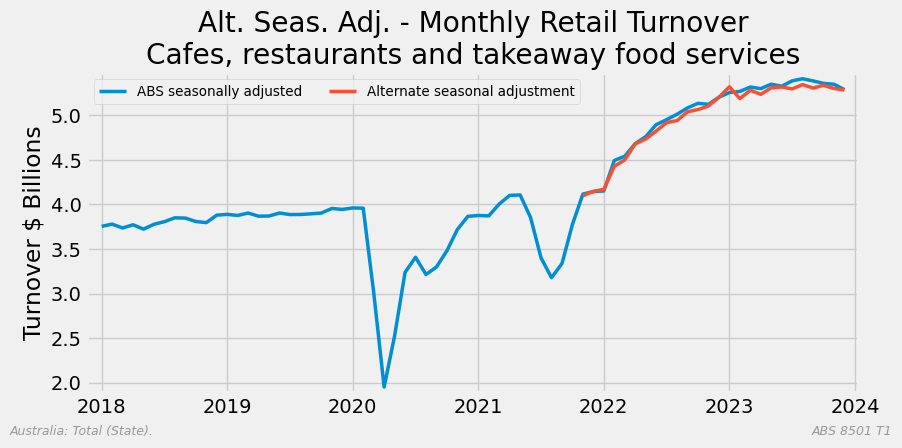

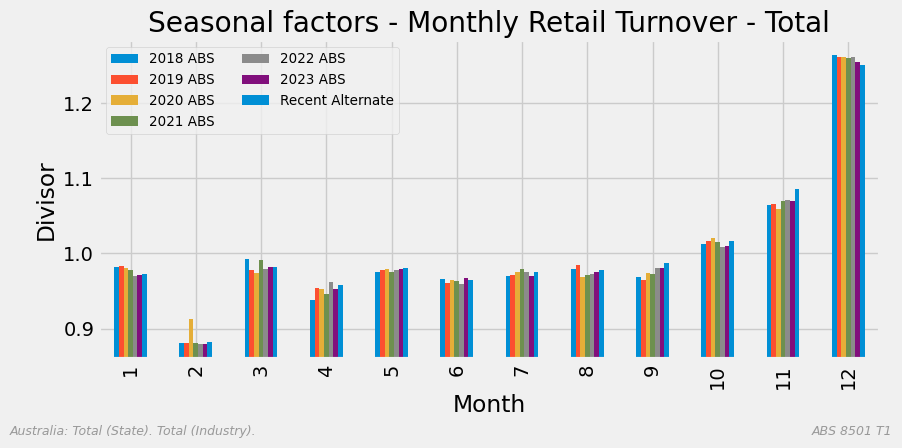

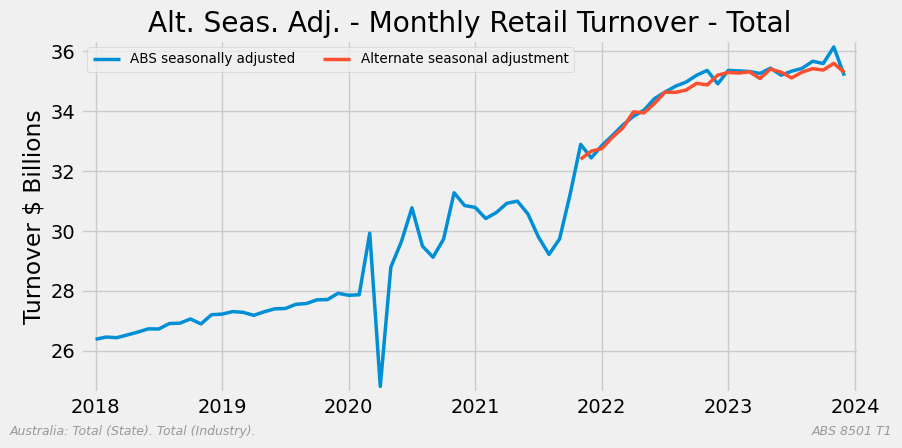

In [12]:
def seasonal() -> None:
    """Produce alternate seasonal adjustment charts."""
    
    table = '1'
    meta = retail_meta[retail_meta.Table == table]
    df = retail_dict[table]
    df = df[df.index.year >= (df.index[-1].year - 5)]

    for did in meta[did_col].unique():

        # extract key data
        data = []
        for seasonal in 'Original', 'Seasonally Adjusted':
            row = meta[
                (meta[did_col] == did)
                & (meta[type_col] == seasonal)
            ]
            id_ = row[id_col].values[0]
            units = row[unit_col].values[0]
            data.append(df[id_])
        factor = pd.DataFrame(data[0] / data[1], columns=['Factor'])
        factor['Year'] = factor.index.year
        factor['Month'] = factor.index.month
        data_table = factor.pivot(values='Factor', index='Month', columns='Year')
        data_table.columns = data_table.columns.astype(str) + " ABS"


        # Let's check how the decomp looks 
        # based on a more recent assessment of seasonality
        # NOTE: highly speculative analysis.
        post_covid = data[0][data[0].index >= pd.Period("2021-11", freq="M")]
        decomp = decompose(
            post_covid, 
            constant_seasonal=True, 
            arima_extend=False,
        )
        months = decomp['Seasonal Weights'].groupby(decomp.index.month).mean()
        data_table['Recent Alternate'] = months

        # chart tidy-up
        title, lfooter = fix_abs_title(did, "")
        title = title.replace('Turnover', '').strip()
        title = '\n' + title if title else title + ' - Total'
        adj = 0.02
        ylim = data_table.min().min() - adj, data_table.max().max() + adj

        # plot
        ax = data_table.plot.bar()
        finalise_plot(
            ax,
            title=f"Seasonal factors - Monthly Retail Turnover{title}",
            ylabel="Divisor",
            xlabel='Month',
            rfooter=f"{source} T{table}",
            lfooter=f"Australia: {lfooter}",
            ylim=ylim,
            legend={"fontsize": "x-small", "ncol": 2},
            show=SHOW,
        )

        # And an ABS  comparative plot.
        alternate = pd.DataFrame(
            [data[1], decomp["Seasonally Adjusted"]],
            index=["ABS seasonally adjusted", "Alternate seasonal adjustment"]
        ).T
        alternate, units = recalibrate(alternate, units)
        ax = alternate.plot(label="ABS Seasonally Adjusted", lw=2.5)
        finalise_plot(
            ax,
            title=f"Alt. Seas. Adj. - Monthly Retail Turnover{title}",
            ylabel=f"Turnover {units}",
            xlabel=None,
            rfooter=f"{source} T{table}",
            lfooter=f"Australia: {lfooter}",
            legend={"fontsize": "x-small", "ncol": 2},
            show=SHOW,
        )


seasonal()

## Finished

In [10]:
# watermark
%load_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Wed Jan 31 2024 07:51:31

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.20.0

pandas    : 2.2.0
matplotlib: 3.8.2

Watermark: 2.4.3



In [11]:
print("Finished")

Finished
